In [20]:
library(randomForest)
library(glmnet)

In [2]:
packageVersion("glmnet")

[1] ‘4.1.6’

In [1]:
whitedata=read.csv("../data/jasa_10_07_2023_data/winequality-white.csv",sep=";")
reddata=read.csv("../data/jasa_10_07_2023_data/winequality-red.csv",sep=";")
whitedata[1:4,]

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
2,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
3,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6


In [22]:
X=whitedata[,1:11]
 Yfull=whitedata[,12]
# tX=reddata[,1:11]
s1=sample(1:nrow(X),nrow(X),replace=FALSE)
X=X[s1,]
Ye=Yfull[s1]
nfull=nrow(X)

In [23]:
# xs=as.matrix(wH[,3:7])
# X=cbind(xs[,1:3],cos(xs[,4])*cos(xs[,5]),cos(xs[,4])*sin(xs[,5]),sin(xs[,4]))
# Yfull=as.numeric(wH[,8])

# s1=sample(1:nrow(X),nrow(X),replace=FALSE)
# X=X[s1,]
# Ye=Yfull[s1]
# nfull=nrow(X)

In [24]:
nrow(X)
length(Ye)
dim(X)

nfull=nrow(X)

[1] 4898

[1] 4898

[1] 4898   11

In [27]:
#with random forest
reps=1:25
rho=seq(0,2,0.1)
MC=matrix(0,nrow=ncol(X),ncol=length(rho))
MC_n=matrix(0,nrow=ncol(X),ncol=length(rho))

RS1=matrix(0,nrow=ncol(X),ncol=length(rho))
RS2=matrix(0,nrow=ncol(X),ncol=length(rho))


trsize=2898
tesize=1000

for(rep in reps)
    {
sn1=sample(1:nrow(X),trsize+tesize,replace=FALSE)
sam1=sn1[1:trsize]
Xtr=X[sam1,]
Y=Ye[sam1]
tr=as.data.frame(cbind(Y,Xtr))

sam2=sn1[(trsize+1):(trsize+tesize)]
Xte=X[sam2,]
Y=Ye[sam2]
te=as.data.frame(cbind(Y,Xte))

size=tesize
split=3
K=size/split

fit=lm(Y~.,tr)
yh=predict(fit,te)
S=abs(yh-te[,1])
Q_90=quantile(S[1:K],0.9)

Ste=S[(K+1):size]
indic=as.factor(as.numeric(Ste>Q_90))
# Xte=te[(K+1):size,2:5]
ten=te[(K+1):size,]

Xval=X[-sn1,]
Yval=Ye[-sn1]
val=as.data.frame(cbind(Yval,Xval))
    
sens_rho=matrix(0,nrow=split-1,ncol=length(rho))

k=1

Var=2:(ncol(tr))
for(var in Var)
    {
for(i in 0:(split-2))
    {
    
    index=1:(size-K)
    index1=index[-(((K*i)+1):(K*(i+1)))]
    index2=index[(((K*i)+1):(K*(i+1)))]
 newtr=as.data.frame(cbind(as.factor(indic[index1]),ten[index1,var]))
 colnames(newtr)=c("I","V1")

    
    pf=randomForest(as.factor(I)~.,newtr,ntree=100,nodesize=50,importance=TRUE,
                        proximity=TRUE)
    

    
     xxx=as.data.frame(cbind(ten[index2,var],ten[index2,var]^2))
 
    colnames(xxx)=c("V1","X12")
    p2=predict(pf, xxx, type = "prob")[,2]

#       xxx=as.data.frame(cbind(tX[,var-1],tX[,var-1]^2))
#       colnames(xxx)=c("V1","X12")
#      etap=predict(pf, xxx, type = "prob")[,2]
    

    k=1
    for(r in rho)
    {
    
#      eta=quantile(etap,1-exp(-r))
    
       eta=quantile(p2,1-exp(-r))
     d1=p2-eta
#     pindf=which(d1>0)
#     d2=mean(p2[pindf])
    d1=d1*(d1>0)
    d2=exp(r)*d1+eta
    d3=exp(r)*(as.numeric(p2>eta))*(as.numeric(indic[index2])-1-p2)

        sens_rho[(i+1),k]=mean(d2)+mean(d3)
        

        
       k=k+1
    
    
    
}
 
    }
    
       sens=colMeans(sens_rho)
    
   
    MCM=sens
    MCM=MCM-MCM[1]+0.1
    
    
    MC[var-1,]=MC[var-1,]+MCM
    
    sens_rho=matrix(0,nrow=split-1,ncol=length(rho))

    
        m=1
for(r in rho)
    {
      X_i=ten[,var]
    q1=quantile(X_i,1-exp(-r))
    q2=-quantile(-X_i,1-exp(-r))
    
    ind1=which(X_i>q1)
    ind2=which(X_i<=q2)
    
    indic1=(as.numeric(Ste[ind1]>Q_90))
    
    indic2=(as.numeric(Ste[ind2]>Q_90))
    
    RS1[var-1,m]=RS1[var-1,m]+mean(indic1)
#      RS1[var-1,m]=RS1[var-1,m]-RS1[var-1,1]+0.1
    
    RS2[var-1,m]=RS2[var-1,m]+mean(indic2)
#      RS2[var-1,m]=RS2[var-1,m]-RS2[var-1,1]+0.1
    m=m+1
    
    }
    
    
    }
}
MC=MC/length(reps)

RS1=RS1/length(reps)
RS2=RS2/length(reps)

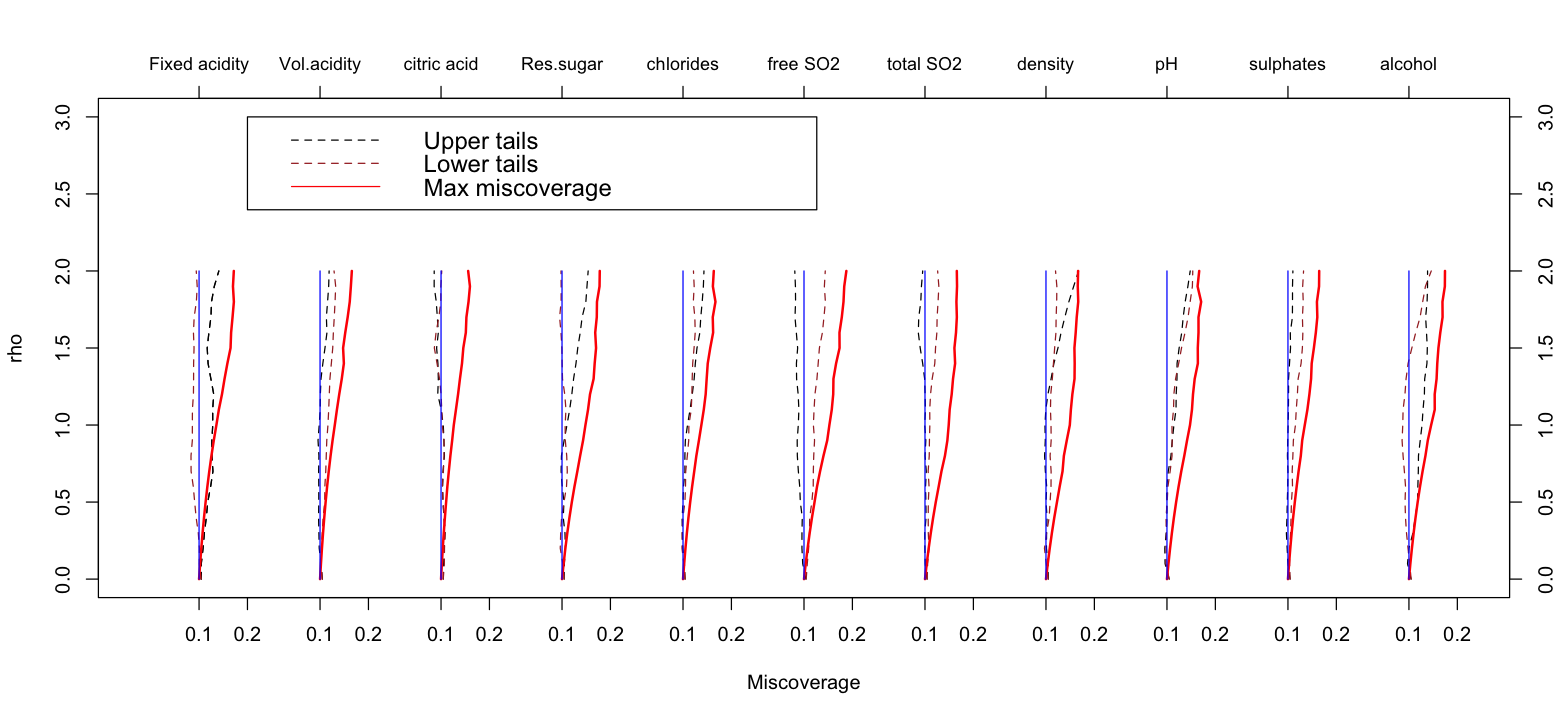

In [42]:
options(repr.plot.width=13, repr.plot.height=6)

inc=0.25
gh=1
thick_up_lo=2
type_of_rs=2

plot(RS1[gh,],rho,xlim=c(0,2.7),ylim=c(0,3),cex.axis=1,xaxt = "n",xlab="Miscoverage",lty=type_of_rs,ty='l')
att=c(0.1,0.2,0.1+inc,0.2+inc,0.1+2*inc,0.2+2*inc,0.1+3*inc,0.2+3*inc,0.1+4*inc,0.2+4*inc,0.1+5*inc,0.2+5*inc,0.1+6*inc,0.2+6*inc,0.1+7*inc,0.2+7*inc,0.1+8*inc,0.2+8*inc,0.1+9*inc,0.2+9*inc,0.1+10*inc,0.2+10*inc)
axis(side=1, at=att, cex.axis=1,labels=c(.1,.2,.1,.2,.1,.2,0.1,.2,.1,.2,.1,.2,.1,.2,.1,.2,.1,.2,.1,.2,.1,.2))



for(gh in 1:length(Var))
    {
    lines(RS1[gh,]+(gh-1)*inc,rho,lty=type_of_rs,ty='l')
lines(RS2[gh,]+(gh-1)*inc,rho,ty='l',lty=type_of_rs,col="brown")
lines(MC[gh,]+(gh-1)*inc,rho,ty='l',lwd=thick_up_lo,col="red")
    lines(c(0.1+(gh-1)*inc,0.1+(gh-1)*inc),c(0,2),ty='l',col="blue")
}
att=c(0.1,0.1+inc,0.1+2*inc,0.1+3*inc,0.1+4*inc,0.1+5*inc,0.1+6*inc,0.1+7*inc,0.1+8*inc,0.1+9*inc,0.1+10*inc)
# axis(1, at=att, labels=c("Humidity","Wind Speed","Visibility","Pressure"))
axis(side=4,cex.axis=1)
axis(side=3, at=att,las=1, cex.lab=1.2,cex.axis=0.9, font=0.3,xlab="Variables", labels=c("Fixed acidity","Vol.acidity","citric acid","Res.sugar","chlorides","free SO2","total SO2","density","pH","sulphates","alcohol"))

legend(0.2,3, legend=c("Upper tails", "Lower tails","Max miscoverage"),
       col=c("black", "brown","red","red"), lty=c(2,2,1,1), cex=1.2)

In [43]:
write.csv(MC,"MC_new.csv")

write.csv(RS1,"RS1_new.csv")
write.csv(RS2,"RS2_new.csv")